TEEN BIRTH RATES EXPLORATION

cleaning and standardizing

In [5]:

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

nchs = pd.read_csv('NCHS_-_U.S._and_State_Trends_on_Teen_Births.csv')
nchs = nchs.rename(columns={
    'State': 'state',
    'State Rate': 'teen_birth_rate',   
    'Age Group (Years)': 'age_group',
    'Year': 'year'
})


policy = pd.read_csv('Sex_Policies.csv')
# Standardize column names
policy.columns = [c.strip() for c in policy.columns]

# Rename for convenience
policy = policy.rename(columns={
    "Jurisdiction": "state",
    "Sex ed mandated": "sex_mand",
    "HIV ed mandated": "hiv_mand",
    "Ed must be medically accurate": "accurate",
    "Ed must be age-appropriate": "ageapp",
    "Ed must include abstinence": "abstinence",
    "Ed must include contraception": "contraception",
    "Ed must cover consent": "consent",
    "Ed must include sexual orientation and gender identity": "sogi",
    "Ed must cover healthy relationships": "relationships"
})

summarize

In [ ]:
# use only columns with yes or no answers
policy1 = policy[['state', 'sex_mand', 'hiv_mand', 'ageapp','contraception', 'consent', 'relationships']]

# Filter for age group 15–19 and year 2019
nchs = nchs[(nchs["age_group"] == "15-19 years") & (nchs["year"] == 2019)].copy()     
nchs_sep = nchs[['state', 'teen_birth_rate']]

nchs_sep = nchs.groupby('state', as_index=False)['teen_birth_rate'].mean()
merged = pd.merge(nchs_sep, policy1, on="state", how="inner")

# Force teen_birth_rate to numeric
merged["teen_birth_rate"] = pd.to_numeric(merged["teen_birth_rate"], errors="coerce")

# Drop rows with missing numeric values
merged = merged.dropna(subset=["teen_birth_rate"])

policy_cols = ["sex_mand","hiv_mand",
               "contraception","consent","relationships"]

summary_table = {}
for col in policy_cols:
    if col in merged.columns:
        means = merged.groupby(col)["teen_birth_rate"].mean()
        summary_table[col] = means.round(2).to_dict()

# Create a table
summary_df = pd.DataFrame(summary_table).T
summary_df.columns = ["No Policy (0)", "Policy Present (1)"]
summary_df.index.name = "Policy Feature"
summary_df = summary_df.sort_index()

print("\nAverage Teen Birth Rate by Policy Feature (2019):\n")
print(summary_df)





Average Teen Birth Rate by Policy Feature (2019):

                No Policy (0)  Policy Present (1)
Policy Feature                                   
consent                 17.58               15.31
contraception           16.80               16.77
hiv_mand                17.44               16.47
relationships           17.58               16.40
sex_mand                16.69               16.85


bar chart

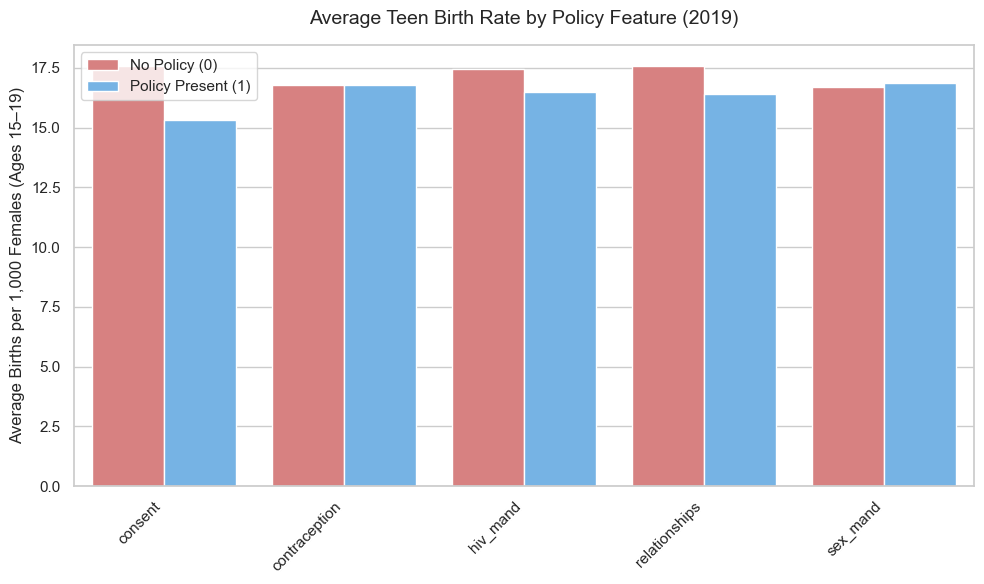

In [ ]:

plot_df = summary_df.reset_index().melt(
    id_vars="Policy Feature",
    var_name="Policy Status",
    value_name="Average Teen Birth Rate"
)

# Set up style
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))

# Create grouped barplot
sns.barplot(
    data=plot_df,
    x="Policy Feature",
    y="Average Teen Birth Rate",
    hue="Policy Status",
    palette=["#E57373", "#64B5F6"]
)

# Customize
plt.title("Average Teen Birth Rate by Policy Feature (2019)", fontsize=14, pad=15)
plt.xticks(rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Average Births per 1,000 Females (Ages 15–19)")
plt.legend(title="")
plt.tight_layout()

plt.show()

grades = pd.read_csv('Insights_US_Sex_ed.csv')

for col in ["overall_grade", "sex_ed_requirement_grade", "content_grade"]:
    grades[col] = grades[col].astype(str).str.strip().str.lower()

grade_map = {
    "a":4.0, "a-":3.7,
    "b+":3.3, "b":3.0, "b-":2.7,
    "c+":2.3, "c":2.0, "c-":1.7,
    "d+":1.3, "d":1.0, "d-":0.7,
    "f":0.0
}

grades["overall_num"] = grades["overall_grade"].map(grade_map)
grades["req_num"]     = grades["sex_ed_requirement_grade"].map(grade_map)
grades["content_num"] = grades["content_grade"].map(grade_map)

grades = grades[["state", "overall_num", "req_num", "content_num"]]
score_cols = {
    "overall_num": "Overall Grade (0–4)",
    "req_num": "Requirement Grade (0–4)",
    "content_num": "Content Grade (0–4)"
}

nchs["state"] = nchs["state"].str.strip().str.lower()

df = (
    nchs
        .merge(grades, on="state", how="inner")
        .dropna(subset=["overall_num", "req_num", "content_num", "teen_birth_rate"])
)

for col, xlabel in score_cols.items():
    plt.figure(figsize=(5,4))
    sns.regplot(data=df, x=col, y="teen_birth_rate", scatter_kws={"alpha":0.8})
    plt.title(f"Teen Birth Rate vs {xlabel}")
    plt.xlabel(xlabel)
    plt.ylabel("Teen Birth Rate (per 1,000, ages 15–19)")
    plt.tight_layout()
    plt.show()

modeling

In [ ]:




formula = "teen_birth_rate ~ overall_num + req_num + content_num"
model = smf.ols(formula, data=df).fit(cov_type="HC3")

print("\nOLS Regression Results:\n")
print(model.summary())

print("\nPlain-English effect sizes:")
for name, coef in model.params.items():
    if name == "Intercept":
        continue
    direction = "lower" if coef < 0 else "higher"
    print(f" • A 1-point increase in {name} → {abs(coef):.2f} {direction} teen births per 1,000 (holding other grades constant).")



Grades preview:
        state  overall_num  req_num  content_num
0     alabama          1.7      2.0          1.3
1      alaska          1.0      1.0          1.0
2     arizona          0.0      0.0          0.0
3    arkansas          0.0      0.0          0.0
4  california          3.7      4.0          3.3

Merged shape: (50, 5)
        state  teen_birth_rate  overall_num  req_num  content_num
0     alabama             25.6          1.7      2.0          1.3
1      alaska             18.3          1.0      1.0          1.0
2     arizona             18.5          0.0      0.0          0.0
3    arkansas             30.0          0.0      0.0          0.0
4  california             12.4          3.7      4.0          3.3

OLS Regression Results:

                            OLS Regression Results                            
Dep. Variable:        teen_birth_rate   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.204
Method: